# 1 Multi-class Classification

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math

## 1.1 Dataset

In [2]:
data = sio.loadmat('data/ex3data1.mat')
data

{'X': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ..., 
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
# X is 5,000 examples of 20x20 pixel images, each image is a handwritten number
# Each 20x20 image is stored as a 400-dimensional vector
data['X'].shape

(5000, 400)

In [4]:
# y is the numeral represented by each image
data['y'].shape

(5000, 1)

In [5]:
# Store in numpy arrays to make things easier
X = data['X']
y = data['y']

## 1.2 Visualizing the data

In [6]:
m = X.shape[0] # number of examples

In [7]:
# Randomly select 100 images to display
rand_indices = np.random.permutation(m)
sel = X[rand_indices[0:100], :]

In [8]:
def displayData(X):
    '''
    Displays 2D data stored in X in a nice grid.
    '''
    m = X.shape[0] # number of images
    display_rows = math.floor(math.sqrt(m))
    display_cols = math.ceil(m / display_rows)
    
    n = X.shape[1] # total number of pixels per image
    image_side = int(math.sqrt(n))
    
    plt.figure(figsize=(8,8))
    
    for i in range(m):
        image = X[i]
        image = np.reshape(image, (image_side, image_side), order='F')
        plt.subplot(display_rows, display_cols, i+1)
        plt.imshow(image, cmap='Greys')
        plt.axis('off')

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

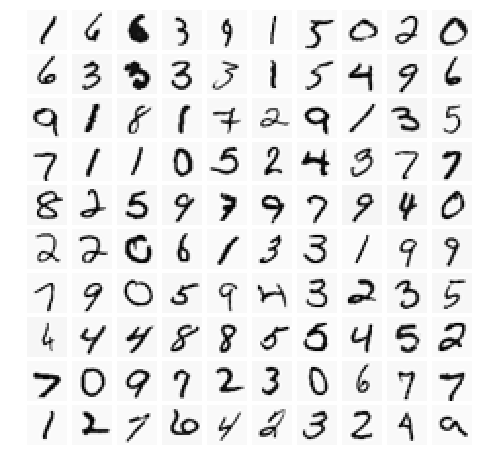

In [9]:
displayData(sel)